<a href="https://colab.research.google.com/github/BanderlogCumberbatch/pnew_find/blob/colab/pnew_find.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
zip_file = '/content/drive/My Drive/chest_xray.zip'

z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

print(os.listdir())

In [ ]:
# Путь к данным
data_dir = {
    'train': '../content/chest_xray/test',
    'test': '../content/chest_xray/test',
    'valid': '../content/chest_xray/val',
}

# Путь к изображениям для проверки
image_path_normal = '../content/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
image_path_pneumonia = '../content/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'

# Размер пакета и количество эпох
batchsize = 32
n_epochs = 0

In [ ]:
# Трансформации для данных
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [ ]:
# Загрузка данных
data_set = {
    'train': datasets.ImageFolder(data_dir['train'], data_transforms['train']),
    'test': datasets.ImageFolder(data_dir['test'], data_transforms['test']),
    'valid': datasets.ImageFolder(data_dir['valid'], data_transforms['valid']),
}

data_loader = {
    'train': torch.utils.data.DataLoader(data_set['train'], batch_size=batchsize, shuffle=True),
    'test': torch.utils.data.DataLoader(data_set['test'], batch_size=batchsize, shuffle=True),
    'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=batchsize, shuffle=True),
}

In [ ]:
# Замена последнего слоя для двух классов (опухоль/нет опухоли)
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)  # 2 класса: опухоль/нет опухоли

c:\Users\PCunit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PCunit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Инициализация функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_function(model, train_loader, valid_loader, criterion, optimizer, scheduler=None,
                   train_on_gpu=False, n_epochs=n_epochs, save_file='C:/Users/PCunit/Desktop/PnewFind/mymodel.pth'):

    valid_loss_min = np.Inf  # Изначально установим минимальный loss как бесконечность
    if train_on_gpu:
        model = model.cuda()

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        # Обучение
        model.train()
        for data, target in train_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        # Валидация
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in valid_loader:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                output = model(data)
                _, predicted = torch.max(output, 1)  # Получаем индекс предсказанного класса
                total += target.size(0)
                correct += (predicted == target).sum().item()

        # Рассчет точности
        accuracy = 100 * correct / total
        print(f'Epoch {epoch}/{n_epochs}.. Accuracy: {accuracy:.2f}%')

        # Сохранение модели (убрали условие, чтобы сохранялась каждый раз)
        torch.save(model.state_dict(), save_file)
        print(f"Модель сохранена в: {save_file}")

    model.to('cpu')  # Перевод модели на CPU после завершения обучения

    # Проверяем, существует ли файл перед загрузкой
    if os.path.exists(save_file):
        return torch.load(save_file)  # Возвращаем модель
    else:
        print("Ошибка: файл модели не найден после обучения.")
        return None



In [ ]:
# Проверка наличия GPU
train_on_gpu = torch.cuda.is_available()


# Запуск обучения, если n_epochs > 0
train_function(model, data_loader['train'], data_loader['valid'], criterion, optimizer, train_on_gpu=train_on_gpu, n_epochs=n_epochs, save_file='mymodel.pth')

C:\Users\PCunit\AppData\Local\Temp\ipykernel_3300\360949531.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/Users/PCunit/Desktop/Pne

In [ ]:
# Функция для проверки точности на тестовом наборе с разделением по классам
def evaluate_model(model, test_loader, device):
    model.eval()  # Переводим модель в режим оценки

    # Счетчики для нормальных и пневмонийных снимков
    correct_normal = 0
    total_normal = 0
    correct_pneumonia = 0
    total_pneumonia = 0

    # Проход по всему тестовому набору
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Обновляем счетчики для нормальных снимков
            normal_mask = labels == 0  # Предполагаем, что класс 0 — "NORMAL"
            correct_normal += (predicted[normal_mask] == labels[normal_mask]).sum().item()
            total_normal += normal_mask.sum().item()

            # Обновляем счетчики для снимков с пневмонией
            pneumonia_mask = labels == 1  # Предполагаем, что класс 1 — "PNEUMONIA"
            correct_pneumonia += (predicted[pneumonia_mask] == labels[pneumonia_mask]).sum().item()
            total_pneumonia += pneumonia_mask.sum().item()

    # Вычисляем точность для каждого класса
    accuracy_normal = 100 * correct_normal / total_normal if total_normal > 0 else 0
    accuracy_pneumonia = 100 * correct_pneumonia / total_pneumonia if total_pneumonia > 0 else 0

    print(f'Точность для нормальных снимков: {accuracy_normal:.2f}%')
    print(f'Точность для снимков с пневмонией: {accuracy_pneumonia:.2f}%')
    print(f'Общая точность на тестовом наборе: {(accuracy_normal + accuracy_pneumonia) / 2:.2f}%')


In [ ]:
# Устройство для выполнения (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Оценка модели на тестовом наборе
evaluate_model(model, data_loader['test'], device)

Точность для нормальных снимков: 77.35%
Точность для снимков с пневмонией: 98.46%
Общая точность на тестовом наборе: 87.91%


In [ ]:
# Функция предсказания на изображении
def predict_image(model, img_path, device):
    model.eval()

    # Трансформации для изображения
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        _, predicted_class = torch.max(output, 1)
        return probabilities, predicted_class

Предсказание для нормального изображения:


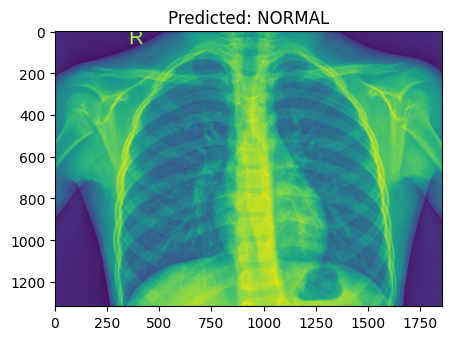

NORMAL: 99.65%
PNEUMONIA: 0.35%

Предсказание для изображения с пневмонией:


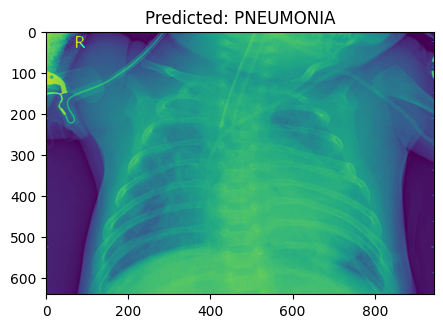

NORMAL: 0.00%
PNEUMONIA: 100.00%


In [ ]:
# Проверка на изображениях
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def show_prediction(image_path, model, class_names):
    probabilities, predicted_class = predict_image(model, image_path, device)

    plt.figure(figsize=(5, 5))
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {class_names[predicted_class.item()]}')
    plt.show()

    # Вывод вероятностей в процентах
    probabilities = probabilities.cpu().numpy() * 100  # Переводим в проценты
    for i, class_name in enumerate(class_names):
        print(f'{class_name}: {probabilities[i]:.2f}%')

# Классы
class_names = ['NORMAL', 'PNEUMONIA']

# Проверка на нормальном изображении
print("Предсказание для нормального изображения:")
show_prediction(image_path_normal, model, class_names)

# Проверка на изображении с пневмонией
print("\nПредсказание для изображения с пневмонией:")
show_prediction(image_path_pneumonia, model, class_names)
